In [2]:
import os
import cv2
import numpy as np

import random
import matplotlib.pyplot as plt

In [ ]:
"""
Run this cell to make the dataset : green bg + only arm 
"""

image_folder = "../Simulation-mask-paired-data/val/B"
mask_folder = "../Simulation-mask-paired-data/val/B-masks"
output_folder = "../arm-green/val/B"


os.makedirs(output_folder, exist_ok=True)
image_filenames = sorted([f for f in os.listdir(image_folder) if f.endswith('.png')])

for filename in image_filenames:
    image_path = os.path.join(image_folder, filename)
    mask_path = os.path.join(mask_folder, filename)
    
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) 

    if image is None or mask is None:
        print(f"Skipping {filename}, missing image or mask.")
        continue

    green_background = np.full_like(image, (0, 255, 0)) 

    object_mask = (mask > 0).astype(np.uint8)

    object_mask_3ch = cv2.merge([object_mask]*3)

    result = np.where(object_mask_3ch == 1, image, green_background)

    output_path = os.path.join(output_folder, filename)
    cv2.imwrite(output_path, result)
    print(f"Saved: {output_path}")


In [11]:
"""
Run this cell to make the dataset : green bg + only arm 
"""


image_path = "../../paired-real-images-and-mask/trainA/0178.png"
mask_path = "../../paired-real-images-and-mask/trainA_seg/0178_0.png"

image = cv2.imread(image_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) 


green_background = np.full_like(image, (0, 255, 0)) 

object_mask = (mask > 0).astype(np.uint8)

object_mask_3ch = cv2.merge([object_mask]*3)

result = np.where(object_mask_3ch == 1, image, green_background)

output_path = "herr_2.png"
cv2.imwrite(output_path, result)
print(f"Saved: {output_path}")


Saved: herr_2.png


In [106]:
image_no = 9

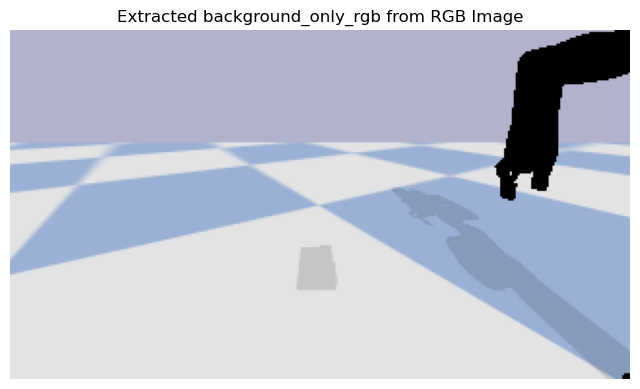

In [107]:
"""
Run this cell to do the inpainting task 

Step 1 : get only the bg of xArm by removing the object in foreground 

Good results : 9 , 90 
"""

rgb_image = cv2.imread(f'../Simulation-mask-paired-data/test/A/image_{image_no}.png') 
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

mask_image = cv2.imread(f'../Simulation-mask-paired-data/test/A-masks/image_{image_no}.png', cv2.IMREAD_GRAYSCALE)

background_mask = (mask_image == 0).astype(np.uint8)
background_mask_3ch = cv2.merge([background_mask]*3)

background_only = rgb_image * background_mask_3ch  # This is already RGB

plt.figure(figsize=(8, 6))
plt.imshow(background_only)
plt.title("Extracted background_only_rgb from RGB Image")
plt.axis('off')
plt.show()


In [108]:
def show_images(images_dict, size_per_image=6):
    """
    Display images in a 2x3 grid with customizable size.
    """
    titles = list(images_dict.keys())
    images = list(images_dict.values())
    
    rows, cols = 2, 3
    plt.figure(figsize=(cols * size_per_image, rows * size_per_image))
    
    for i in range(len(images)):
        plt.subplot(rows, cols, i + 1)
        img = images[i]
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
        plt.title(titles[i], fontsize=14)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


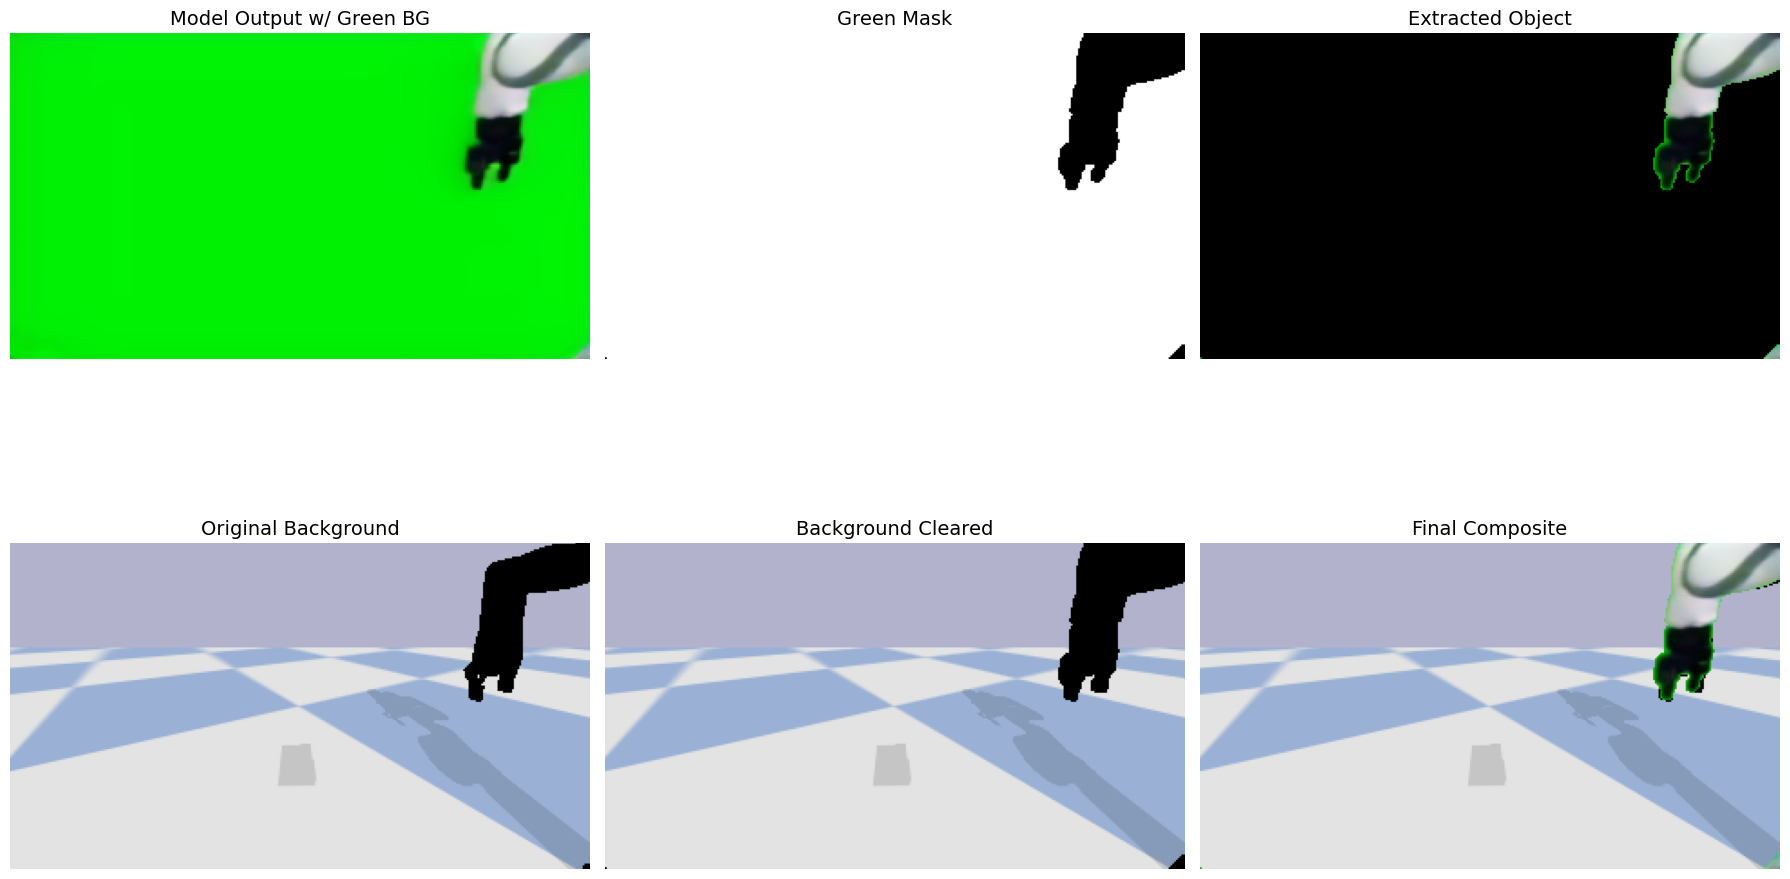

In [109]:
"""
Step 2 : overlay the model's output on this 
"""


image_with_green = cv2.imread(f'../green-bg-only-arm-results/sample_to_eval/200/image_{image_no}/output_0.png')

image_with_green = cv2.resize(image_with_green, (background_only.shape[1], background_only.shape[0]))

lower_green = np.array([0, 180, 0])
upper_green = np.array([100, 255, 100])
green_mask = cv2.inRange(image_with_green, lower_green, upper_green)

object_mask = cv2.bitwise_not(green_mask)
object_mask_3ch = cv2.merge([object_mask // 255]*3)
object_only = image_with_green * object_mask_3ch

background_mask_3ch = cv2.merge([(green_mask // 255)]*3) # take the green from the model's output 
background_only_bgr = cv2.cvtColor(background_only, cv2.COLOR_RGB2BGR)
background_cleared = background_only_bgr * background_mask_3ch

composited_image = object_only + background_cleared
composited_rgb = cv2.cvtColor(composited_image, cv2.COLOR_BGR2RGB)

image_with_green_rgb = cv2.cvtColor(image_with_green, cv2.COLOR_BGR2RGB)
object_only_rgb = cv2.cvtColor(object_only, cv2.COLOR_BGR2RGB)
background_cleared_rgb = cv2.cvtColor(background_cleared, cv2.COLOR_BGR2RGB)

show_images({
    "Model Output w/ Green BG": image_with_green_rgb,
    "Green Mask": green_mask,
    "Extracted Object": object_only_rgb,
    "Original Background": background_only,
    "Background Cleared": background_cleared_rgb,
    "Final Composite": composited_rgb
})


In [110]:
def plot_triplet(input_img, model_output, inpainted_result, size_per_image=6):
    """
    Plots 3 images side by side:
    - input_img: Original input image (RGB or grayscale)
    - model_output: Output from model
    - inpainted_result: Final result after inpainting
    """
    titles = ["Input Image", "Model Output", "Inpainted Result"]
    images = [input_img, model_output, inpainted_result]

    plt.figure(figsize=(3 * size_per_image, size_per_image))
    
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        img = images[i]
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
        plt.title(titles[i], fontsize=14)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


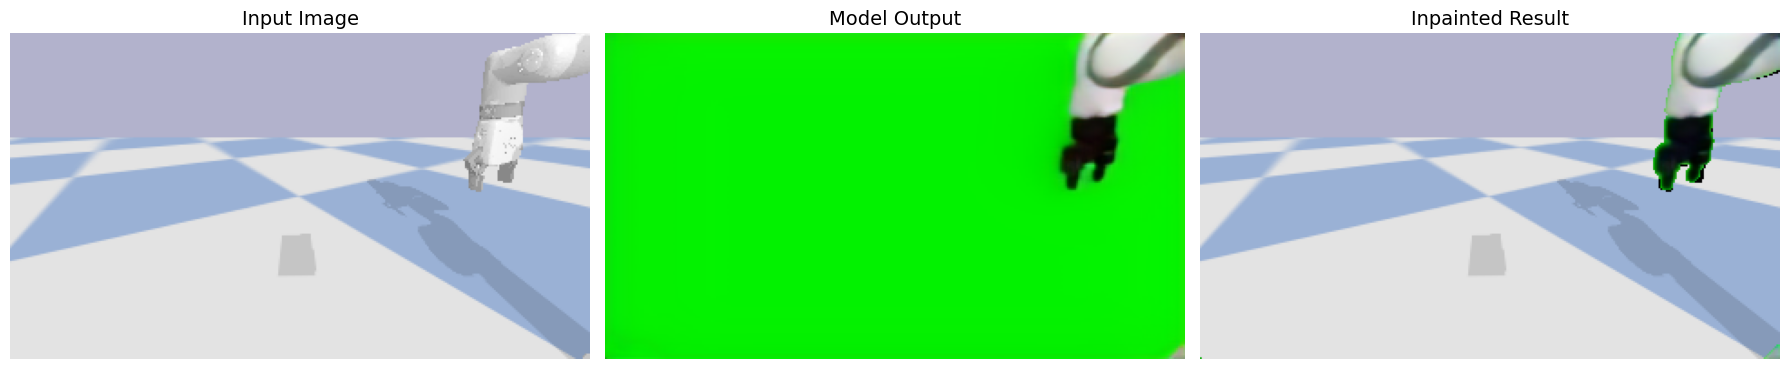

In [111]:
plot_triplet(rgb_image, image_with_green, composited_rgb)

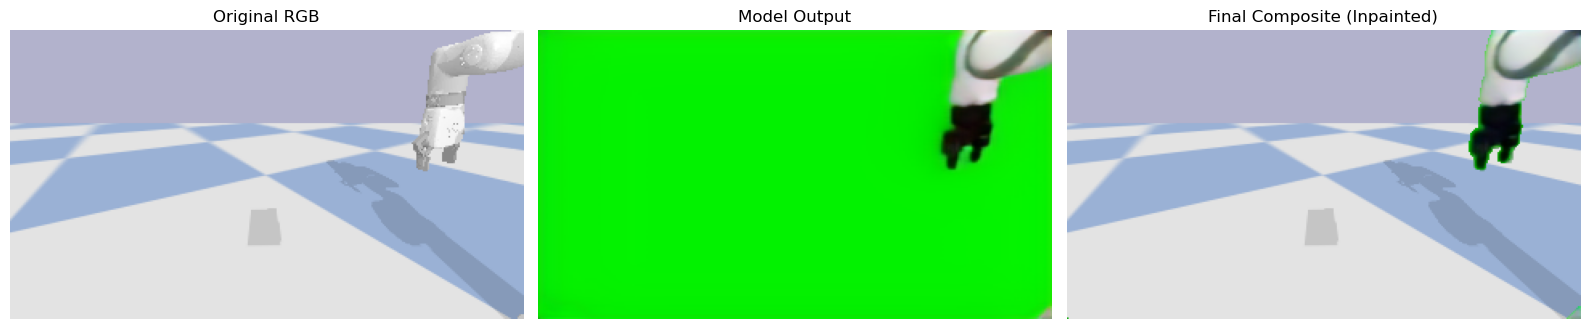

In [112]:
composited_bgr = cv2.cvtColor(composited_rgb, cv2.COLOR_RGB2BGR)

black_mask = np.all(composited_bgr == [0, 0, 0], axis=2).astype(np.uint8) * 255

# Inpaint using TELEA method
inpainted_bgr = cv2.inpaint(composited_bgr, black_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

inpainted_rgb = cv2.cvtColor(inpainted_bgr, cv2.COLOR_BGR2RGB)

def plot_triplet(img1, img2, img3, titles=["Original RGB", "Model Output", "Final Composite (Inpainted)"]):
    plt.figure(figsize=(16, 6))
    for i, (img, title) in enumerate(zip([img1, img2, img3], titles)):
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_triplet(rgb_image, image_with_green, inpainted_rgb)


In [5]:
"""
Arm - coloured dataset
"""

base_input = "../Simulation-mask-paired-data/train"
base_output = "../arm-colored/train"

domains = ['A', 'B']
input_folders = {d: os.path.join(base_input, d) for d in domains}
mask_folders = {d: os.path.join(base_input, f"{d}-masks") for d in domains}
output_folders = {d: os.path.join(base_output, d) for d in domains}

for folder in output_folders.values():
    os.makedirs(folder, exist_ok=True)

image_filenames = sorted([
    f for f in os.listdir(input_folders['A']) 
    if f.endswith('.png') and os.path.exists(os.path.join(input_folders['B'], f))
])

for filename in image_filenames:

    bg_color = tuple(random.randint(0, 255) for _ in range(3))
    print(f"Processing {filename} with background color {bg_color}")

    for domain in domains:
        image_path = os.path.join(input_folders[domain], filename)
        mask_path = os.path.join(mask_folders[domain], filename)
        output_path = os.path.join(output_folders[domain], filename)

        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            print(f"Skipping {filename} in domain {domain}, missing image or mask.")
            continue

        background = np.full_like(image, bg_color)
        object_mask = (mask > 0).astype(np.uint8)
        object_mask_3ch = cv2.merge([object_mask] * 3)

        result = np.where(object_mask_3ch == 1, image, background)
        cv2.imwrite(output_path, result)
        print(f"Saved: {output_path}")


Processing image_0.png with background color (79, 177, 95)
Saved: ../arm-colored/train/A/image_0.png
Saved: ../arm-colored/train/B/image_0.png
Processing image_1.png with background color (66, 25, 154)
Saved: ../arm-colored/train/A/image_1.png
Saved: ../arm-colored/train/B/image_1.png
Processing image_10.png with background color (114, 20, 181)
Saved: ../arm-colored/train/A/image_10.png
Saved: ../arm-colored/train/B/image_10.png
Processing image_100.png with background color (18, 159, 250)
Saved: ../arm-colored/train/A/image_100.png
Saved: ../arm-colored/train/B/image_100.png
Processing image_1000.png with background color (184, 172, 33)
Saved: ../arm-colored/train/A/image_1000.png
Saved: ../arm-colored/train/B/image_1000.png
Processing image_1001.png with background color (216, 45, 22)
Saved: ../arm-colored/train/A/image_1001.png
Saved: ../arm-colored/train/B/image_1001.png
Processing image_1002.png with background color (24, 184, 80)
Saved: ../arm-colored/train/A/image_1002.png
Saved